In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt

In [2]:
T = 370+273.15 #Temperature of operation in K.

P = 1e7 #Pressure in inlet in Pa.

rho0 = 914.6 #Density of oil at 15.6°C in kg/m^3.

rhob = 0.8163 #bulk density in g/cm^3

roW = 999.007 #density of water at 15.6°C in kg/m^3.

Mm1 = 420 #molecuar weigth of the oil.

porosity = 0.48 #value calculate using values of first article = 0.48

eta = 0.5

dp = 0.172 #equivalent diameter in cm

diameter_reactor = 3 #diameter of the reactor in cm

T_MeABP = (451 + 273.15)*1.8 # Mean average boiling point of oil in °R.


w1 = 0.02 #weigth fraction of sulfur.

Vn = 8.3145*273.15/101325*1000 #Volume molar at standard conditions in Nl.

alfa1 = 7 #first coeficient of gas-liquid mass transfer in cm^(-1.6).

alfa2 = 0.4 #second coeficient of gas-liquid mass transfer

d15_6 = rho0/roW #Specific gravity of oil.

def get_API(specific_gravity):

    '''Get the API gravity of oil.

        Parameters
        ----------
        specific_gravity: float

       Returns
       -------
       The API gravity of oil.
       API: float

    '''
    return 141.5/specific_gravity - 131.5

API = get_API(d15_6) #API gravity of oil.

vc1_m = 7.5214e-3*T_MeABP**0.2896*d15_6**(-0.7666) #critical specific volume in ft^3/lb.

vc_2 = 65.1 #critical specific volume of hydrogen in cm^3/mol.

vc_4 = 98.6 #critical specific volume of hydrogen sulfite in cm^3/mol.

vc1 = vc1_m*Mm1*62.4279 #critical specific volume of the oil in cm^3/mol.

v1 = 0.285*vc1**1.048 #volume molar of the oil in cm^3/mol.

v2 = 0.285*vc_2**1.048   #volume molar of hydrogen in cm^3/mol.

v4 = 0.285*vc_4**1.048   #volume molar of hydrogen sulfite in cm^3/mol.

WHSV = 0.90 #weight hour velocity

In [5]:
def deltarhoP(rho0,P):

    '''Function to get the density of oil corretion with pressure.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in lb/ft^3.
        
        P: int or float
           Pressure in psia.

        Returns
        -------
        deltarhoP: float
                  Density correction with pressure in lb/ft^3.

    '''

    return ((0.167 + (16.181*10**(-0.0425*rho0)))*(P/1000) - 0.01*(0.299 + (263*10**(-0.0603*rho0)))*(P/1000)**2)

def deltarhoT(rho0, P, T):

    '''Function to get the density of oil corretion with temperature.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in lb/ft^3.
        
        P: int or float
           Pressure in psia.
    
        T: int or float
           Temperature in  °R.

        Returns
        -------
        deltarhoT: float
                  Density correction with temperature in lb/ft^3.

    '''

    return ((0.0133 + 152.4*(rho0 + deltarhoP(rho0,P))**(-2.45)))*(T-520) - (8.1*10**(-6) - 0.0622*10**((-0.764)*(rho0 + deltarhoP(rho0,P))))*(T-520)**2

def oil_density(rho0,P,T):

    '''Get the density of oil in function of pressure and temperature.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        oil_density: float
                  Density correction with temperature and pressure in g/cm^3.

    '''    

    rho0 = rho0/16.018
    T = 1.8*T
    P = P*14.7/101325

    return (rho0 + deltarhoP(rho0,P) - deltarhoT(rho0,P,T))*0.016018

In [ ]:
fi = 1.100 #lN H2 / g feed

In [ ]:
Ac = np.pi*diameter_reactor**2/4

In [ ]:
GL = 0.00572 # Mass flow in g/(cm^2*s).

uG = 0.1606 #superficial gas velocity in cm/s

uL = 7.552e-3 #superficial liquid velocity in cm/s.


Gl = WHSV*160/Ac/3600
uL = GL/oil_density(rho0,P,T)
uG = uL*1000*(1/100)*(T/273.15)

In [ ]:
def ciL(w,rho0,P,T):
    
    '''Get the concentration of organic compound.
    
        Parameters
        ----------
        wi: The weight fraction of compound.

        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        ciL: float
             The concentration of organic compound in mol/cm^3.

    '''    
    return oil_density(rho0,P,T)*w/Mm1

def Lambda2(T):

    '''Function to get the solubility of hydrogen in hydrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in K.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen in (Nl H2,)/[(g oil)*(MPa)].
    '''
    T = T - 273.15

    ro_20 = oil_density(rho0,101325,293.15)

    return  (-0.559729 - 0.42947e-3*T + 3.07539e-3*T/ro_20 + 1.94593e-6*T**2 + 0.835783/ro_20**2)   

def Henry_coefficient2_fun(rho0 = rho0, P = P, T = T):

    '''Function to get the Henry coefficient of hydrogen in hydrocarbon mixtures.
     
        rho0: int or float
            Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        H: float
           The Henry coefficient for hydrogen in MPa.cm^3/mol. '''  

    
    return Vn/(Lambda2(T)*oil_density(rho0,P,T)/1000)

def Lambda4(T=T):

   '''Function to get the solubility of hydrogen sulfite in hidrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in °C.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen sulfite in (Nl H2S,)/[(g oil)*(MPa)].
    '''
   T = T - 273.15

   return np.exp(3.3670 - 0.008470*T)

def Henry_coefficient4_fun(rho0 = rho0, P = P, T = T):

    '''Function to get the Henry coefficient of hydrogen sulfite in hydrocarbon mixtures. 

        Parameters
        ----------

        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        H: float
           The Henry coefficient for hydrogen sulfite in MPa.cm^3/mol. '''  

    return Vn/(Lambda4(T)*oil_density(rho0,P,T)/1000)

def mi_L(T,API=API):

    '''Function to get the viscosity of oil.

    Parameters
    ----------
    API: float or int
         API gravity of oil.   
    
    T: int or float
       Temperature in K.

    Returns
    -------
    mi_L: float
          Viscosity of oil sulfite in g/(cm*s).'''

    T = T*1.8

    a = 10.313*np.log10(T - 460) - 36.447

    return 3.141e10*(T - 460)**(-3.444)*((np.log10(API))**a)/100

def specific_gravity(API=API):

    '''Get the specific gravity of oil.
    Parameters
    ----------
    API: int or float

    Returns
    -------
    The specific_gravity of oil.
    specific_gravity: float

    '''
    return 141.5/(API + 131.5)

def D1L(T = T):

    '''Gets the coefficient of diffusivity of the organic sulfur compound in solution in cm^2/s.

    Parameters
    ----------
    T: int or float
       Temperature in K.
    
    Returns
    -------
    D1L: float
          The difusivity coefficient.
    '''

    return (8.93e-8*(v1**0.267)*T)/((v1**0.433)*(mi_L(T)*100))

def D2L(T = T):

    '''Gets the coefficient of diffusivity of hydrogen in solution in cm^2/s.

    Parameters
    ----------
    T: int or float
       Temperature in K.
    
    Returns
    -------
    D2L: float
          The difusivity coefficient.
    '''

    return (8.93e-8*(v1**0.267)*T)/((v2**0.433)*(mi_L(T)*100))

def D4L(T = T):

    '''Gets the coefficient of diffusivity of hydrogen sulfite in solution in cm^2/s.

    Parameters
    ----------
    T: int or float
       Temperature in K.
    
    Returns
    -------
    D2L: float
          The difusivity coefficient.
    '''

    return 8.93e-8*v1**0.267*T/v4**0.433/(mi_L(T)*100)

def k2L_aL_fun(rho0 = rho0, P = P, T = T): 
    
   '''Get the gas-liquid mass transfer coefficient from liquid to particle for hydrogen.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k2Lat: float
             Mass transfer coefficient in s^-1.'''
   
     
   return D2L(T)*alfa1*(GL/mi_L(T))**alfa2*(mi_L(T)/(oil_density(rho0,P,T)*D2L(T)))**(0.5)

def k4L_aL_fun(rho0 = rho0, P = P, T = T): 
    
   '''Get the gas-liquid mass transfer coefficient from liquid to particle for hydrogen sulfite.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k4Lat: float
             Mass transfer coefficient in s^-1.'''
   
     
   return D4L(T)*alfa1*(GL/mi_L(T))**alfa2*(mi_L(T)/(oil_density(rho0,P,T)*D4L(T)))**(0.5)

def aS_fun(dp=0.172,porosity = 0.5):

    '''Gets the specific surface area of the packing.

        Parameters
        ----------
        dp: int or float
            equivalent diameter in cm.

        porosity: int or float
                  The void fraction of the catalystic bed.

        Return
        ------
        a_super: float
                 The specific surface area of the packing in cm^-1.
    '''

    return 6*(1-porosity)/dp

def k1S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for organic sulfur compound.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k1S: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D1L(T)*aS_fun()*1.8*(GL/(mi_L(T)*aS_fun()))**0.5*(mi_L(T)/(oil_density(rho0,P,T)*D1L(T)))**(1/3)

def k2S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for hydrogen.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k2S: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D2L(T)*aS_fun()*1.8*(GL/(mi_L(T)*aS_fun()))**0.5*(mi_L(T)/(oil_density(rho0,P,T)*D2L(T)))**(1/3)

def k4S_fun(rho0 = rho0, P = P, T = T):

    '''Get the mass transfer coefficient from liquid to particle for hydrogen sulfite.
    
        Parameters
        ----------
        rho0: int or float
             Density at standard conditions (15,6°C; 101.3 kPa) in g/cm^3.
        
        P: int or float
           Pressure in Pa.
    
        T: int or float
           Temperature in K.

        Returns
        -------
        k4sat: float
             Mass transfer coefficient from liquid to particle in s^-1.'''

    return D4L(T) * aS_fun()*1.8 * (GL/(mi_L(T)*aS_fun()))**0.5 * (mi_L(T)/(oil_density(rho0,P,T)*D4L(T)))**(1/3)


def k(k0, Ea, T, R=8.3145):
    """Calculate the cinetic constant of Arrhneius.

    Args:
        k0 (float): the pre-exponencial factor.
        Ea (float): activation energy in [kJ/mol].
        T(float): Temperature in [K].
        R (float): The gas constant in [J/(mol.K)].

    Returns:
        float: The constant cinetic.
    """
    return k0 * np.exp(-Ea*1e3 / (R * T))
    
def fKH2S(T = T, k0 = 41769.8411, delta_Hads=2761 ,R = 8.3145):
    """Calculate the equilibrium constant of hydrodessulfulrization.

    Args:
        T(float): Temperature in [K].
        k0 (float): the pre-exponencial factor.
        delta_Hads (float): delta energy of adsorption in [J/mol].
        R (float): The gas constant in [J/(mol.K)].

    Returns:
        float: The equilibrium constant in [cm^3/mol].

    """
    return  k0* np.exp(delta_Hads / (R * T))

In [ ]:
H2 = Henry_coefficient2_fun()

H4 = Henry_coefficient4_fun()

KH2S = fKH2S()

k2L_aL = k2L_aL_fun()

#k2L_aL = 7.05e-3

k4L_aL = k4L_aL_fun()

#k4L_aL = 6.42e-3

k1S_aS = k1S_fun()*aS_fun()

#k1S_aS = 2.76e-2

k2S_aS = k2S_fun()*aS_fun()

#k2S_aS = 7.06e-2

k4S_aS = k4S_fun()*aS_fun()


In [ ]:
def Lambda2(T):

    '''Function to get the solubility of hydrogen in hydrocarbon mixtures.

    Parameters
    ----------
    T: int or float
       Temperature in K.

    Returns
    -------
    Lambda2: float
             Solubility of hydrogen in (Nl H2,)/[(g oil)*(MPa)].
    '''
    T = T - 273.15

    ro_20 = oil_density(rho0,101325,293.15)

    return  (-0.559729 - 0.42947e-3*T + 3.07539e-3*T/ro_20 + 1.94593e-6*T**2 + 0.835783/ro_20**2)   

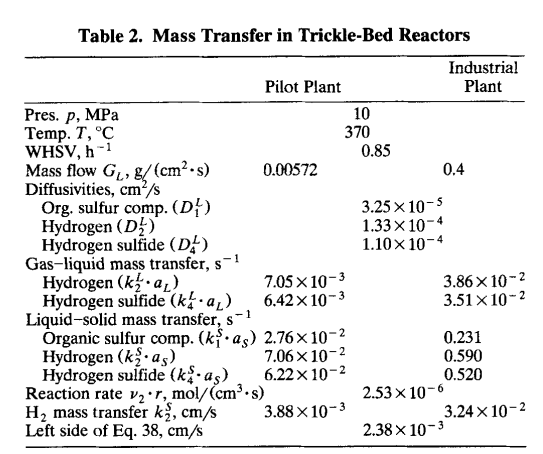

![Alt text](image-1.png)

In [ ]:
def k_app():

    A = 0.21
    B = 1.40
    G = 0.0572
    kin = 0.67

    return (A/G**B + 1/kin)**-1

def rHDS(CS, CH2, CH2S, T = T):
    """ Calculate the HDS reaction rate.
    Args:
        CS (float): Concentration of sulfur compounds in [mol/cm^3].
        CH2 (float): Concentration of hydrogen in [mol/cm^3].
        CH2S (float): Concentration of hydrogen sulfide in [mol/cm^3].
        T (float): Temperature in [K].

    Returns:
        float: The HDS reaction rate in [mol/s].
    """

    #return k(0.545e6, 72.5, T) * CS * CH2**0.45/(1 + KH2S * CH2S)**2
    return k_app() * CS * CH2**0.45/(1 + KH2S * CH2S)**2

In [ ]:

def mass_balance_gas_phase2(p2G, C2L,H2, uG = uG, R=8.3145, T = T): #equation 7

    return - k2L_aL * (p2G / H2 - C2L) * R * T / uG 

def mass_balance_gas_phase4(p4G, C4L, H4, uG = uG, R=8.3145, T = T): #equation 8

    return - k4L_aL * (p4G / H4- C4L) * R * T / uG

def mass_balance_gas_liquid_phase2(p2G, C2L, C2S, H2, uL = uL): #equation 9

    return (k2L_aL * (p2G / H2 - C2L) -  k2S_aS * (C2L - C2S)) / uL

def mass_balance_gas_liquid_phase4(p4G, C4L, C4S, H4, uL = uL): #equation 10
    
    return (k4L_aL * (p4G / H4 - C4L) -  k4S_aS * (C4L - C4S)) / uL

def mass_balance_liquid(C1L, C1S, uL = uL): #equation 11

    return - (C1L - C1S) * k1S_aS / uL

In [ ]:
def constraints(C,liquid_concentrations):

    ni1 = -1 
    ni2 = -15
    ni4 = 9
    efectiveness = 1

    C1S = C[0]
    C2S = C[1]
    C4S = C[2]

    F = np.empty((3))
    F[0] =  - ni1*eta*efectiveness*rhob *rHDS(C1S, C2S, C4S) - k1S_aS*(liquid_concentrations[0] - C1S)
    F[1] =  - ni2*eta*efectiveness*rhob *rHDS(C1S, C2S, C4S) - k2S_aS*(liquid_concentrations[1] - C2S)
    F[2] =  - ni4*eta*efectiveness*rhob *rHDS(C1S, C2S, C4S) - k4S_aS*(liquid_concentrations[2] - C4S)

    return F

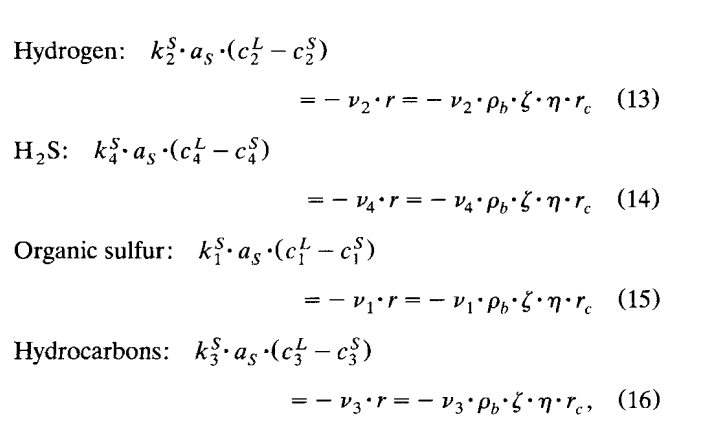

In [ ]:
p2G0 = 10 # inlet pressure of gas hydrogen in MPa.
p4G0 = 0 # inlet pressure of hydrogen sulfite in MPa.
C1L0 = oil_density(rho0,P,T)*w1/Mm1 #inlet concentration of sulfur liquid in mol/cm^3.   #fórmula funciona :)
C2L0 = p2G0/H2 #inlet concentration of hydrogen in mol/cm^3 .
C4L0 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .
z0=0
z = 70 #lenght of reactor in cm.z

In [ ]:
C0s = [0,0,0]
Cls = [C1L0, C2L0, C4L0]

In [ ]:
def dy(z, variables,H2,H4):

    p2G, p4G, C2L, C4L,  C1L = variables
    
    if z==z0:
        solid_concentrations = root(constraints, Cls, Cls, method = "hybr").x
    else:
        #solid_concentrations = root(constraints, [C1L, C2L, C4L], [C1L, C2L, C4L], method = "hybr").x
        solid_concentrations = root(constraints, Cls, [C1L, C2L, C4L], method = "hybr").x


    return np.array([mass_balance_gas_phase2(p2G, C2L,H2),
     mass_balance_gas_phase4(p4G, C4L,H4),
     mass_balance_gas_liquid_phase2(p2G, C2L, solid_concentrations[1],H2),
     mass_balance_gas_liquid_phase4(p4G, C4L, solid_concentrations[2],H4),
     mass_balance_liquid(C1L, solid_concentrations[0])
    ])

In [ ]:
t_span = [z0, z]
t_eval = np.linspace(0, z, 1000)
y0 = [p2G0, p4G0, C2L0, C4L0, C1L0]

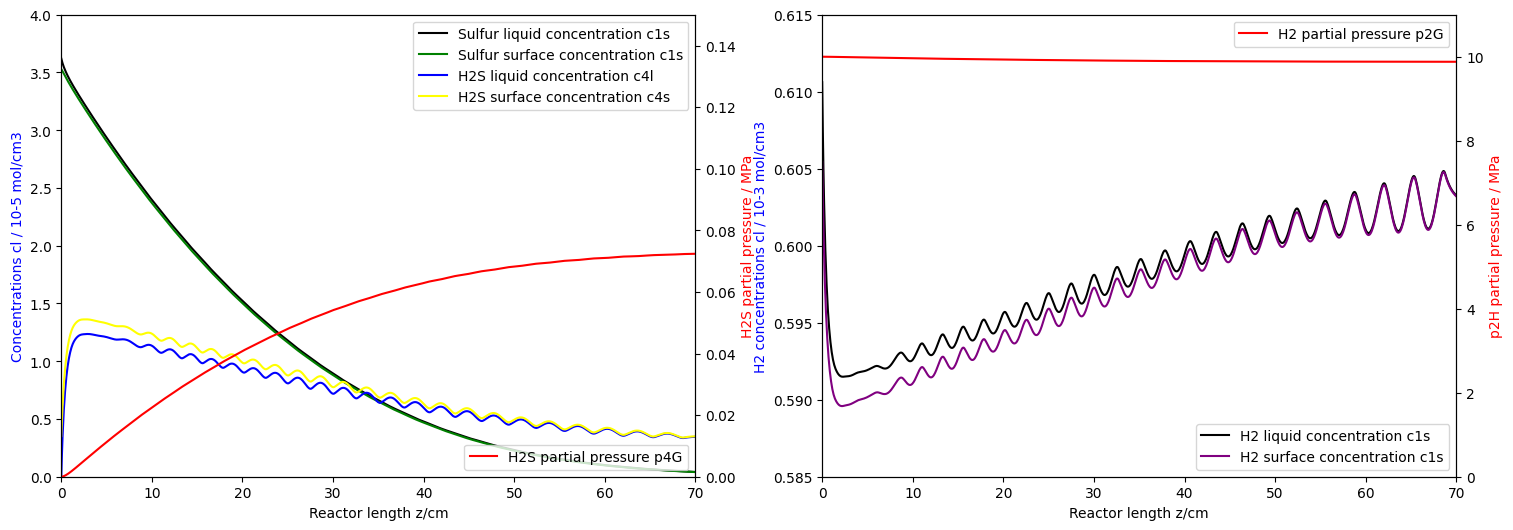

In [ ]:
sol = solve_ivp(dy, t_span=t_span, y0=y0, t_eval=t_eval, method = "RK45",args=(H2,H4))

p2G_fun, p4G_fun, C2L_fun, C4L_fun,  C1L_fun = sol.y

CS1_fun = []
CS2_fun = []
CS4_fun = []

for i in range(len(C2L_fun)):

    [CS1, CS2, CS4] = root(constraints, [C1L_fun[i], C2L_fun[i], C4L_fun[i]], [C1L_fun[i], C2L_fun[i], C4L_fun[i]], method = "hybr",).x

    CS1_fun.append(CS1)
    CS2_fun.append(CS2)
    CS4_fun.append(CS4)

CS1_fun = np.array(CS1_fun)
CS2_fun = np.array(CS2_fun)
CS4_fun = np.array(CS4_fun)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first dataset (y_values1) on the left axis (Y-axis)
ax[0].plot(t_eval, C1L_fun*1e5, label='Sulfur liquid concentration c1s', color='black')
ax[0].plot(t_eval, CS1_fun*1e5, label='Sulfur surface concentration c1s', color='green')
ax[0].plot(t_eval, C4L_fun*1e5, label='H2S liquid concentration c4l', color='blue')
ax[0].plot(t_eval, CS4_fun*1e5, label='H2S surface concentration c4s', color='yellow')

ax[0].set_xlim(0,z)
ax[0].set_ylim(0,4)
# Create a second Y-axis on the right side of the graph
ax2 = ax[0].twinx()

# Plot the second dataset (y_values2) on the right axis (Y-axis)
ax2.plot(t_eval, p4G_fun, label='H2S partial pressure p4G', color='red')
# Add labels and a legend
ax[0].set_xlabel('Reactor length z/cm')
ax[0].set_ylabel('Concentrations cl / 10-5 mol/cm3', color='blue')
ax2.set_ylabel('H2S partial pressure / MPa', color='red')
ax2.set_ylim(0,0.15)

# Add a legend
ax[0].legend(loc='upper right')
ax2.legend(loc='lower right')

ax[1].plot(t_eval, C2L_fun*1e3, label='H2 liquid concentration c1s', color='black')
ax[1].plot(t_eval, CS2_fun*1e3, label='H2 surface concentration c1s', color='purple')



ax[1].set_xlim(0, z)
ax[1].set_ylim(0.585,0.615)
# Create a second Y-axis on the right side of the graph
ax4 = ax[1].twinx()

# Plot the second dataset (y_values2) on the right axis (Y-axis)
ax4.plot(t_eval, p2G_fun, label='H2 partial pressure p2G', color='red')
# Add labels and a legend
ax[1].set_xlabel('Reactor length z/cm')
ax[1].set_ylabel('H2 concentrations cl / 10-3 mol/cm3', color='blue')
ax4.set_ylabel('p2H partial pressure / MPa', color='red')
ax4.set_ylim(0,11)

# Add a legend
ax[1].legend(loc='lower right')
ax4.legend(loc='upper right')


# Display the graph
plt.show()


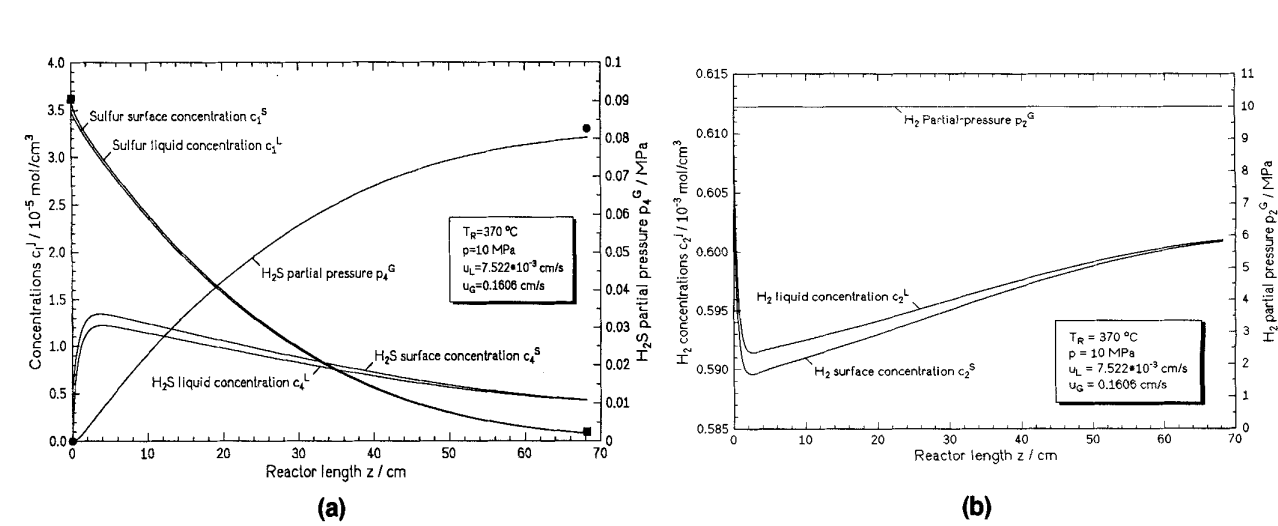